In [9]:
# sliding window GRU with attention, downsampling, and full evaluation
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Claudia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.Wa = self.add_weight(name='Wa', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.ba = self.add_weight(name='ba', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.va = self.add_weight(name='va', shape=(input_shape[-1], 1), initializer='glorot_uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        uit = tf.tanh(tf.tensordot(inputs, self.Wa, axes=1) + self.ba)
        ait = tf.nn.softmax(tf.tensordot(uit, self.va, axes=1), axis=1)
        weighted_input = inputs * ait
        return tf.reduce_sum(weighted_input, axis=1)
    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        return config

In [11]:
# Load and preprocess data
SEED = 42
np.random.seed(SEED)
df = pd.read_csv("msd_dataset_enriched_with_similar_songs.csv")
df = df[~df['genre'].isna() & ~df['lyrics'].isna()]
stopwords_set = set(stopwords.words('english'))

def clean_lyrics(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    tokens = text.split()
    return ' '.join([t for t in tokens if t not in stopwords_set])

df['cleaned_lyrics'] = df['lyrics'].apply(clean_lyrics)
genre_counts = df['genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 20].index
df = df[df['genre'].isin(valid_genres)]


In [12]:
# Dynamically downsample overly dominant genres
threshold = 0.3 * len(df)
balanced_dfs = []
for genre, count in df['genre'].value_counts().items():
    genre_df = df[df['genre'] == genre]
    if count > threshold:
        genre_df = resample(genre_df, replace=False, n_samples=int(threshold), random_state=SEED)
    balanced_dfs.append(genre_df)
df = pd.concat(balanced_dfs).sample(frac=1, random_state=SEED)

# Tokenization
tokenized = df['cleaned_lyrics'].apply(str.split)
w2v_model = Word2Vec(sentences=tokenized, vector_size=50, window=5, min_count=3, workers=4)
valid_words = set(w2v_model.wv.index_to_key)

# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_lyrics'])
filtered_index = {word: i+1 for i, word in enumerate(valid_words)}
tokenizer.word_index = filtered_index
tokenizer.index_word = {i: word for word, i in filtered_index.items()}

# Sliding windows
X_seq = []
y_seq = []
labels = df['genre'].tolist()
tokenized_seqs = tokenizer.texts_to_sequences(df['cleaned_lyrics'])

In [13]:
def create_sliding_windows(seq, window_size=100, step_size=50):
    windows = []
    for start in range(0, len(seq) - window_size + 1, step_size):
        windows.append(seq[start:start+window_size])
    if not windows and len(seq) > 0:
        windows.append(seq[:window_size])
    return windows

for i, seq in enumerate(tokenized_seqs):
    windows = create_sliding_windows(seq, window_size=100, step_size=50)
    for window in windows:
        padded = pad_sequences([window], maxlen=100)[0]
        X_seq.append(padded)
        y_seq.append(labels[i])

X = np.array(X_seq)
le = LabelEncoder()
y_labels = le.fit_transform(y_seq)
y = to_categorical(y_labels)

embedding_matrix = np.zeros((len(filtered_index) + 1, 50))
for word, i in filtered_index.items():
    embedding_matrix[i] = w2v_model.wv[word]

In [14]:
# Metadata features
meta_features = ['duration','tempo','key','loudness'] + [
    f'pitch_mean_{i}' for i in range(12)
] + [f'pitch_std_{i}' for i in range(12)] + [f'timbre_mean_{i}' for i in range(12)] + [f'timbre_std_{i}' for i in range(12)]
df[meta_features] = df[meta_features].fillna(0)
scaler = StandardScaler()


meta_rows = []
for i, seq in enumerate(tokenized_seqs):
    windows = create_sliding_windows(seq, window_size=100, step_size=50)
    num_windows = len(windows)
    meta_row = df.iloc[i][meta_features].values
    for _ in range(num_windows):
        meta_rows.append(meta_row)

X_meta_all = np.array(meta_rows)
X_meta_all = scaler.fit_transform(X_meta_all)

In [15]:
# Train/test split
X_train_lyrics, X_temp_lyrics, X_train_meta, X_temp_meta, y_train, y_temp, y_train_labels, y_temp_labels = train_test_split(
    X, X_meta_all, y, y_labels, test_size=0.3, stratify=y_labels, random_state=SEED
)

X_val_lyrics, X_test_lyrics, X_val_meta, X_test_meta, y_val, y_test, y_val_labels, y_test_labels = train_test_split(
    X_temp_lyrics, X_temp_meta, y_temp, y_temp_labels, test_size=0.5, stratify=y_temp_labels, random_state=SEED
)

In [16]:
# Model with Attention
input_lyrics = Input(shape=(100,))
x = Embedding(input_dim=embedding_matrix.shape[0], output_dim=50, weights=[embedding_matrix], trainable=False)(input_lyrics)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = AttentionLayer()(x)
x = Dropout(0.3)(x)

input_meta = Input(shape=(X_train_meta.shape[1],))
combined = Concatenate()([x, input_meta])
output = Dense(y.shape[1], activation='softmax')(combined)

model = Model(inputs=[input_lyrics, input_meta], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model.fit([X_train_lyrics, X_train_meta], y_train,
          validation_data=([X_val_lyrics, X_val_meta], y_val),
          batch_size=64, epochs=20, callbacks=[early], verbose=1)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.1431 - loss: 2.7803 - val_accuracy: 0.3447 - val_loss: 2.1244
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.3552 - loss: 2.1507 - val_accuracy: 0.3960 - val_loss: 1.9515
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.4090 - loss: 1.9804 - val_accuracy: 0.4302 - val_loss: 1.8834
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.4428 - loss: 1.8285 - val_accuracy: 0.4587 - val_loss: 1.7993
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.4886 - loss: 1.6764 - val_accuracy: 0.4786 - val_loss: 1.7616
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.4943 - loss: 1.6294 - val_accuracy: 0.4672 - val_loss: 1.7257
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.5111 - loss: 1.6162 - val_accuracy: 0.4843 - val_loss: 1.6935
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.5080 - loss: 1.5792 - val_accuracy: 0.49

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

Test Accuracy: 0.5242165242165242

Classification Report:
              precision    recall  f1-score   support

       Blues       1.00      0.25      0.40         8
     Country       0.40      0.35      0.38        17
  Electronic       0.00      0.00      0.00        10
        Folk       0.00      0.00      0.00         3
        Jazz       0.67      0.15      0.25        13
       Latin       0.40      0.29      0.33         7
       Metal       0.54      0.30      0.39        23
         Pop       0.37      0.37      0.37        41
    Pop Rock       0.50      0.15      0.24        13
        Punk       0.50      0.18      0.27        11
         Rap       0.69      0.88      0.77        83
      Reggae       0.20      0.06      0.10        16
         RnB       0.00      0.00      0.00         6
        Rock       0.47      0.80      0.60        90
  Rock Metal       0.00      0.00      0.00         6
   Rock Punk       0.00      0.00   

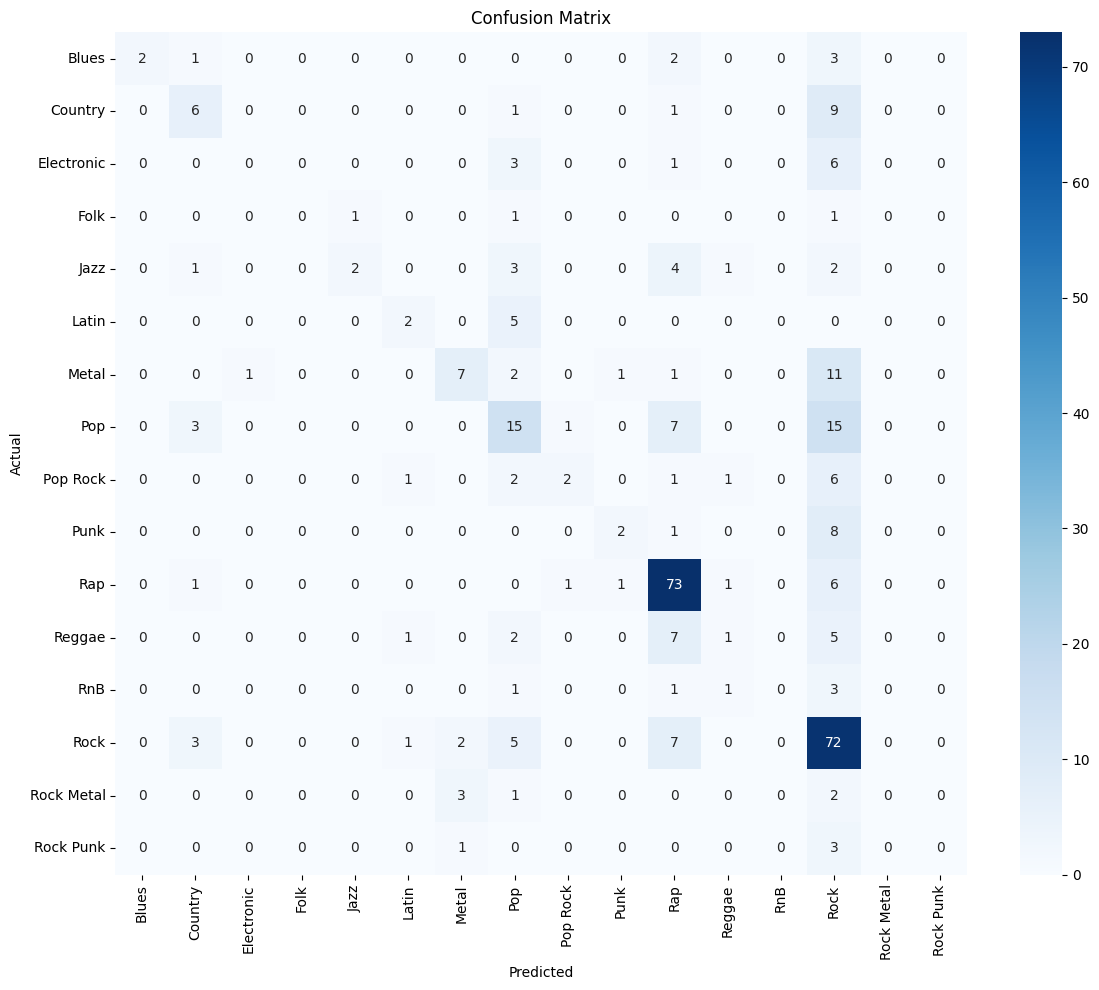

In [17]:
# Evaluation
y_pred = np.argmax(model.predict([X_test_lyrics, X_test_meta]), axis=1)
y_true = y_test_labels

print("\nTest Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [18]:
# Predict
y_pred = np.argmax(model.predict([X_test_lyrics, X_test_meta]), axis=1)
test_acc = accuracy_score(y_test_labels, y_pred)
print(f"Test Accuracy on held-out set: {test_acc:.4f}")

# Random sample of predictions vs actual
sample_idxs = np.random.choice(len(X_test_lyrics), size=5, replace=False)
for i in sample_idxs:
    actual = le.inverse_transform([y_test_labels[i]])[0]
    predicted = le.inverse_transform([y_pred[i]])[0]
    print(f"\nSample {i}")
    print("Actual Genre   :", actual)
    print("Predicted Genre:", predicted)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test Accuracy on held-out set: 0.5242

Sample 157
Actual Genre   : Pop
Predicted Genre: Pop

Sample 342
Actual Genre   : Rock
Predicted Genre: Pop

Sample 316
Actual Genre   : Jazz
Predicted Genre: Jazz

Sample 234
Actual Genre   : Rock
Predicted Genre: Rock

Sample 155
Actual Genre   : Pop
Predicted Genre: Country


In [32]:
model.save("gru_atten_model.h5")

In [33]:
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


### Lyrics Only Model ###


Training GRU+Attention model using only lyrics...
Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.2042 - loss: 2.5174 - val_accuracy: 0.3675 - val_loss: 2.1651
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.3366 - loss: 2.1861 - val_accuracy: 0.3846 - val_loss: 2.0687
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.3928 - loss: 2.0576 - val_accuracy: 0.3875 - val_loss: 2.0143
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.3976 - loss: 2.0211 - val_accuracy: 0.3960 - val_loss: 1.9738
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.4202 - loss: 1.9434 - val_accuracy: 0.4217 - val_loss: 1.9636
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.4294 - loss: 1.8936 - val_accuracy: 0.4160 - val_loss: 1.9320
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.4355 - loss: 1.8652 - val_accuracy: 0.4160 - val_loss: 1.9362
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step -

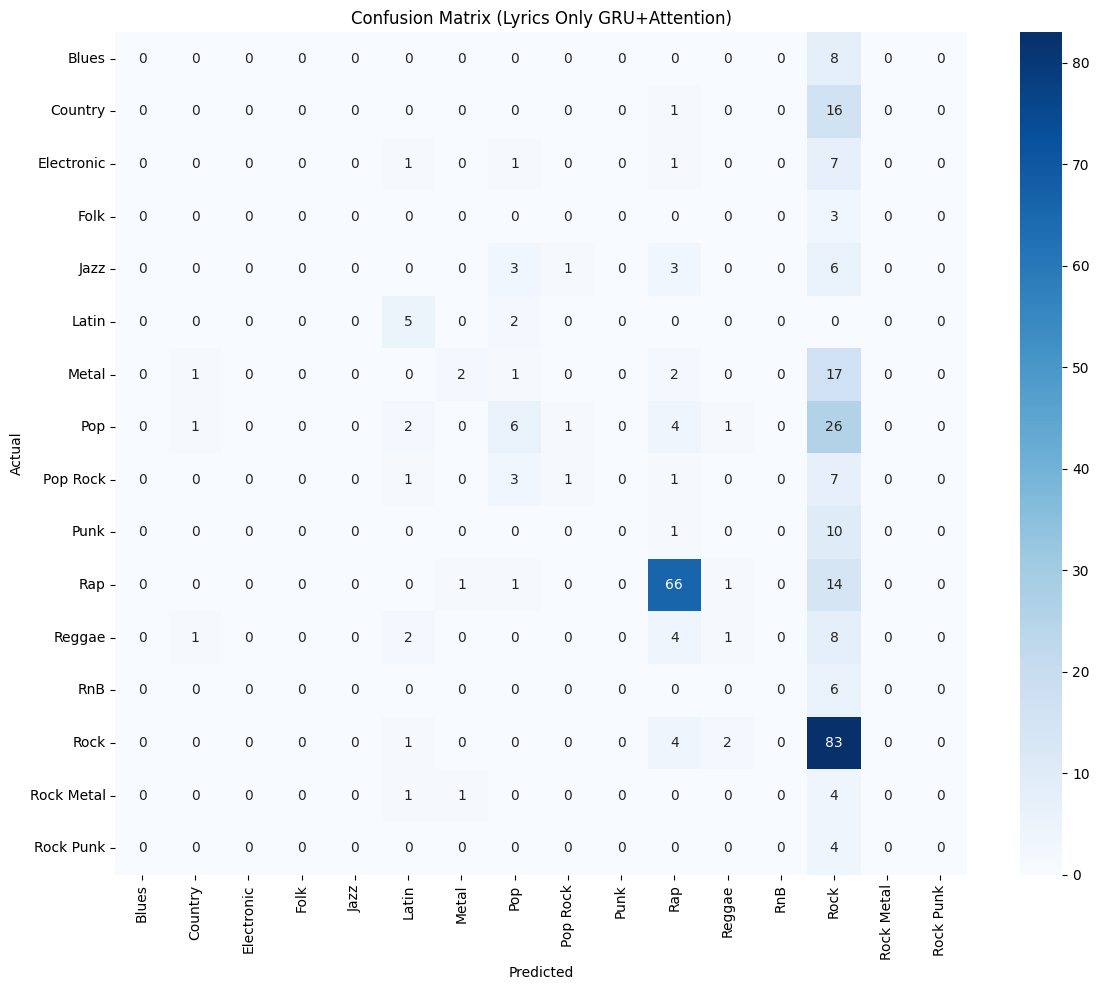

In [20]:
print("\nTraining GRU+Attention model using only lyrics...")

input_lyrics = Input(shape=(100,))
x = Embedding(input_dim=embedding_matrix.shape[0], output_dim=50,
              weights=[embedding_matrix], trainable=False)(input_lyrics)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = AttentionLayer()(x)
x = Dropout(0.3)(x)
output = Dense(y.shape[1], activation='softmax')(x)

model_lyrics_only = Model(inputs=input_lyrics, outputs=output)
model_lyrics_only.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
model_lyrics_only.fit(X_train_lyrics, y_train,
                      validation_data=(X_val_lyrics, y_val),
                      batch_size=64, epochs=20, callbacks=[early], verbose=1)

# Evaluate on test set
y_pred_lyrics = np.argmax(model_lyrics_only.predict(X_test_lyrics), axis=1)
print("\n[Lyrics Only] Classification Report:")
print(classification_report(y_test_labels, y_pred_lyrics, target_names=le.classes_, zero_division=0))

cm = confusion_matrix(y_test_labels, y_pred_lyrics)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Lyrics Only GRU+Attention)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



Training GRU+Attention: GRU=32, Attention=32, Dropout=0.2
→ Validation Accuracy: 0.5043

Training GRU+Attention: GRU=32, Attention=32, Dropout=0.3
→ Validation Accuracy: 0.5299

Training GRU+Attention: GRU=32, Attention=32, Dropout=0.5
→ Validation Accuracy: 0.5299

Training GRU+Attention: GRU=32, Attention=64, Dropout=0.2
→ Validation Accuracy: 0.4815

Training GRU+Attention: GRU=32, Attention=64, Dropout=0.3
→ Validation Accuracy: 0.4815

Training GRU+Attention: GRU=32, Attention=64, Dropout=0.5
→ Validation Accuracy: 0.5071

Training GRU+Attention: GRU=32, Attention=128, Dropout=0.2
→ Validation Accuracy: 0.5071

Training GRU+Attention: GRU=32, Attention=128, Dropout=0.3
→ Validation Accuracy: 0.5043

Training GRU+Attention: GRU=32, Attention=128, Dropout=0.5
→ Validation Accuracy: 0.5185

Training GRU+Attention: GRU=64, Attention=32, Dropout=0.2
→ Validation Accuracy: 0.4758

Training GRU+Attention: GRU=64, Attention=32, Dropout=0.3
→ Validation Accuracy: 0.5185

Training GRU+Atte

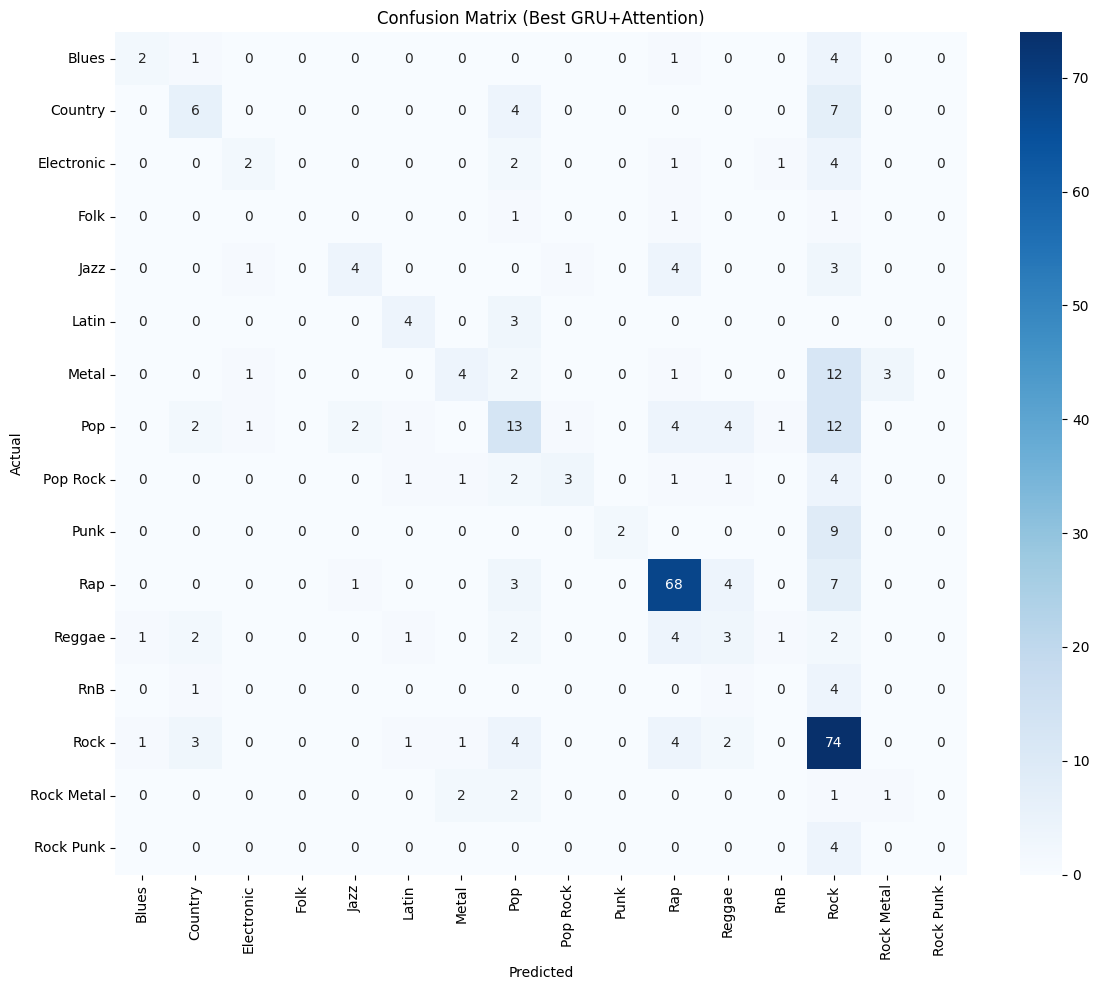

In [21]:
class AttentionLayer(Layer):
    def __init__(self, attention_units=64, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.attention_units = attention_units

    def build(self, input_shape):
        self.Wa = self.add_weight(name='Wa', shape=(input_shape[-1], self.attention_units),
                                  initializer='glorot_uniform', trainable=True)
        self.ba = self.add_weight(name='ba', shape=(self.attention_units,),
                                  initializer='zeros', trainable=True)
        self.va = self.add_weight(name='va', shape=(self.attention_units, 1),
                                  initializer='glorot_uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        uit = tf.tanh(tf.tensordot(inputs, self.Wa, axes=1) + self.ba)
        ait = tf.nn.softmax(tf.tensordot(uit, self.va, axes=1), axis=1)
        weighted_input = inputs * ait
        return tf.reduce_sum(weighted_input, axis=1)

    def get_config(self):
        config = super().get_config()
        config.update({"attention_units": self.attention_units})
        return config


best_acc = 0
best_model = None
best_params = {}

for gru_units in [32, 64, 128]:
    for attention_units in [32, 64, 128]:
        for dropout_rate in [0.2, 0.3, 0.5]:
            print(f"\nTraining GRU+Attention: GRU={gru_units}, Attention={attention_units}, Dropout={dropout_rate}")

            input_lyrics = Input(shape=(100,))
            x = Embedding(input_dim=embedding_matrix.shape[0], output_dim=50,
                          weights=[embedding_matrix], trainable=False)(input_lyrics)
            x = Bidirectional(GRU(gru_units, return_sequences=True))(x)
            x = AttentionLayer(attention_units=attention_units)(x)
            x = Dropout(dropout_rate)(x)

            input_meta = Input(shape=(X_train_meta.shape[1],))
            combined = Concatenate()([x, input_meta])
            output = Dense(y.shape[1], activation='softmax')(combined)

            model = Model(inputs=[input_lyrics, input_meta], outputs=output)
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            early = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
            model.fit([X_train_lyrics, X_train_meta], y_train,
                      validation_data=([X_val_lyrics, X_val_meta], y_val),
                      batch_size=64, epochs=20, callbacks=[early], verbose=0)

            val_loss, val_acc = model.evaluate([X_val_lyrics, X_val_meta], y_val, verbose=0)
            print(f"→ Validation Accuracy: {val_acc:.4f}")

            if val_acc > best_acc:
                best_acc = val_acc
                best_model = model
                best_params = {
                    "gru_units": gru_units,
                    "attention_units": attention_units,
                    "dropout": dropout_rate
                }

print(f"\n✅ Best Validation Accuracy: {best_acc:.4f} with params: {best_params}")

# Evaluate on test set
y_pred_best = np.argmax(best_model.predict([X_test_lyrics, X_test_meta]), axis=1)
print("\n[Best GRU+Attention Model] Classification Report:")
print(classification_report(y_test_labels, y_pred_best, target_names=le.classes_, zero_division=0))

cm_best = confusion_matrix(y_test_labels, y_pred_best)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Best GRU+Attention)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
